In [2]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
chars_locs = {
    100: 'http://3.90.70.101:8000/arb-blacklist-08-03-2020/topic_model100_weight_and_threshold0.05/time_series_characteristics.csv',
    200: 'http://3.90.70.101:8000/arb-blacklist-08-03-2020/topic_model200_weight_and_threshold0.05/time_series_characteristics.csv',
    300: 'http://3.90.70.101:8000/arb-blacklist-08-03-2020/topic_model300_weight_and_threshold0.05/time_series_characteristics.csv',
    400: 'http://3.90.70.101:8000/arb-blacklist-08-03-2020/topic_model400_weight_and_threshold0.05/time_series_characteristics.csv',
    500: 'http://3.90.70.101:8000/arb-blacklist-08-03-2020/topic_model500_weight_and_threshold0.05/time_series_characteristics.csv',
}

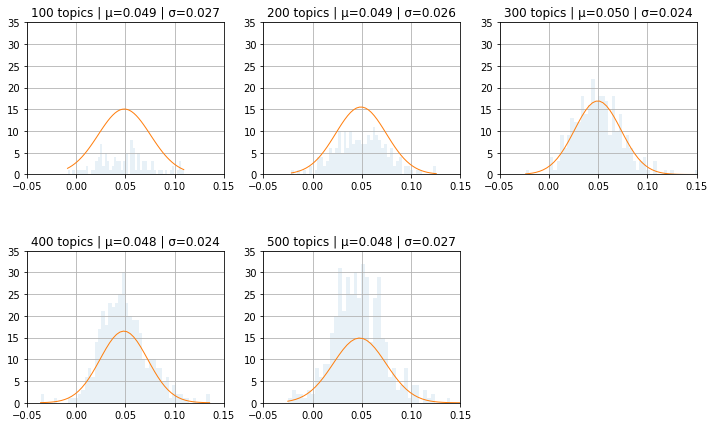

In [4]:
agg_df = pd.DataFrame()
plt.figure(figsize = (12, 7))
for i, (n_topics, chars_loc) in enumerate(chars_locs.items()):

    df = pd.read_csv(chars_loc, index_col=0)
    
    xmin = df['CAGR'].min()
    xmax = df['CAGR'].max()
    mu = df['CAGR'].mean()
    std = df['CAGR'].std()
    
    plt.subplot(2, 3, i+1)
    df['CAGR'].hist(alpha=0.1, bins=50) # this number of bins just for visuals
    x = np.linspace(xmin, xmax, 50)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=1)
    plt.ylim(0, 35)
    plt.xlim(-0.05, 0.15)
    df['n_topics'] = n_topics
    agg_df = agg_df.append(df)
    plt.title(f"{n_topics} topics | μ={mu:.3f} | σ={std:.3f}")
#     plt.ylim(0, 30)
    plt.subplots_adjust(hspace=0.5)

plt.show()
# plt.legend()

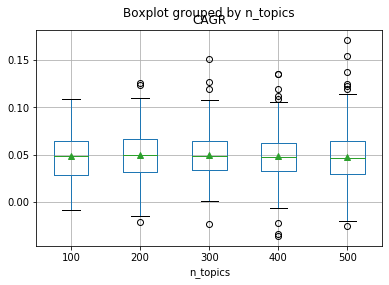

In [274]:
agg_df.boxplot('CAGR', by='n_topics', showmeans=True)
fig = plt.gcf()

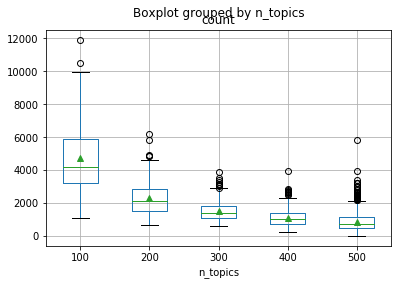

In [276]:
agg_df.boxplot('count', by='n_topics', showmeans=True)

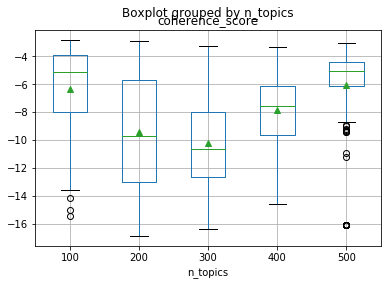

In [277]:
agg_df.boxplot('coherence_score', by='n_topics', showmeans=True)

In [23]:
tn_topics = []
topic_n_outliers = []
topic_n_threesigs = []
for n_topics, _ in chars_locs.items():

    tmp_df = agg_df[agg_df['n_topics'] == n_topics]
    q1 = tmp_df['CAGR'].quantile(0.25)
    q3 = tmp_df['CAGR'].quantile(0.75)
    iqr = q3 - q1
    outlier_thresh = q3 + 1.5 * iqr
    filtered = tmp_df.query('CAGR > (@outlier_thresh)')
    n_outliers = filtered.shape[0]
    topic_n_outliers.append(n_outliers)
    
    three_sig = tmp_df['CAGR'].mean() + 3 * tmp_df['CAGR'].std()
    filtered = tmp_df.query('CAGR > (@three_sig)')
    n_threesigs = filtered.shape[0]
    topic_n_threesigs.append(n_threesigs)
    
    tn_topics.append(n_topics)

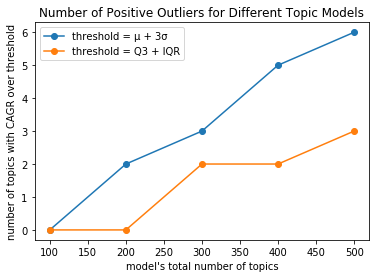

In [27]:
plt.plot(tn_topics, topic_n_outliers, marker='o', label=f'threshold = μ + 3σ')
plt.plot(tn_topics, topic_n_threesigs, marker='o', label=f'threshold = Q3 + IQR')
plt.xlabel('model\'s total number of topics')
plt.ylabel('number of topics with CAGR over threshold')
plt.title('Number of Positive Outliers for Different Topic Models')
plt.legend()

Seems that greater number of topics in the model leads to more topics which have a significantly greater CAGR. Some possible explanations:  
1) There are more topics overall, so there are more outliers.  
2) Too few topics leads to topics being lumped together which could wash out eachother's trends over time. 